In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
from collections import OrderedDict
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler 
import torchvision
from torchvision import transforms, datasets, models
import time
import copy
import os

In [0]:
directory = "/content/drive/My Drive/driver_dataset/"

In [0]:
mean_nums = [0.5, 0.5, 0.5]
std_nums = [0.5, 0.5, 0.5]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [0]:
# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(directory, x), chosen_transforms[x]) for x in ['train', 'val']}

In [0]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=5, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [0]:
class_names = chosen_datasets['train'].classes
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
used_cuda = torch.cuda.is_available()
device = torch.device("cuda" if used_cuda else "cpu")

In [0]:
num_classes = len(class_names)

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

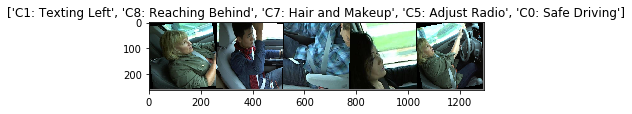

In [10]:
inputs, classes = next(iter(dataloaders['train']))

picture = torchvision.utils.make_grid(inputs)

imshow(picture, title=[class_names[x] for x in classes])

In [0]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
    ("Last Layer", nn.Linear(in_features=4096, out_features=num_classes, bias=True)),
]))
vgg16.classifier[6] = classifier

In [0]:
vgg16 = vgg16.to(device)
    
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    training_loss = []
    validation_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() 
            else:
                model.eval() 

            curr_loss = 0.0
            curr_corrects = 0

            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)
              
              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                   
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

              curr_loss += loss.item() * inputs.size(0)
              curr_corrects += torch.sum(preds == labels.data)

            epoch_loss = curr_loss / dataset_sizes[phase]
            epoch_acc = curr_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #to plot the graph of train and val losses
            if phase == 'train':
              training_loss.append(epoch_loss)
            elif phase == 'val':
              validation_loss.append(epoch_loss)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "/content/drive/My Drive/driver_dataset/best_model")

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, training_loss, validation_loss

In [0]:
def visualize_model(model, num_images=4):
    train = model.training
    model.eval()
    images = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images += 1
                ax = plt.subplot(num_images//2, 2, images)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images == num_images:
                    model.train(mode=train)
                    return model.train(mode=train)

Epoch 0/14
----------
Iterating through data...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.8139 Acc: 0.3542
Iterating through data...
val Loss: 0.8654 Acc: 0.7151

Epoch 1/14
----------
Iterating through data...
train Loss: 1.4920 Acc: 0.4807
Iterating through data...
val Loss: 0.6506 Acc: 0.7692

Epoch 2/14
----------
Iterating through data...
train Loss: 1.3594 Acc: 0.5256
Iterating through data...
val Loss: 0.4481 Acc: 0.8555

Epoch 3/14
----------
Iterating through data...
train Loss: 1.2559 Acc: 0.5650
Iterating through data...
val Loss: 0.4845 Acc: 0.8320

Epoch 4/14
----------
Iterating through data...
train Loss: 1.2107 Acc: 0.5791
Iterating through data...
val Loss: 0.3266 Acc: 0.8905

Epoch 5/14
----------
Iterating through data...
train Loss: 1.1461 Acc: 0.6024
Iterating through data...
val Loss: 0.3375 Acc: 0.8802

Epoch 6/14
----------
Iterating through data...
train Loss: 0.9854 Acc: 0.6580
Iterating through data...
val Loss: 0.2211 Acc: 0.9321

Epoch 7/14
----------
Iterating through data...
train Loss: 0.8923 Acc: 0.6882
Iterating through data..

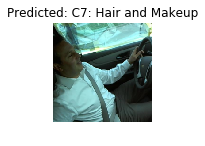

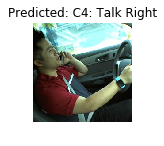

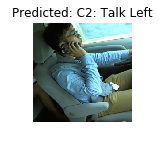

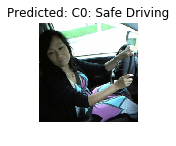

In [15]:
vgg16_model, trainloss, validloss = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)
visualize_model(vgg16_model)
plt.show()

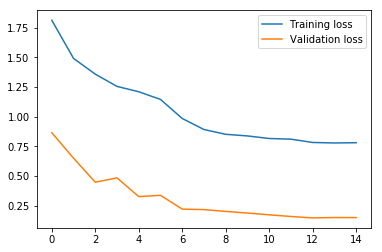

In [16]:
plt.plot(trainloss, label='Training loss')
plt.plot(validloss, label="Validation loss")
plt.legend()
plt.show()